**A note for learning [statmorph](https://statmorph.readthedocs.io/en/latest/)**  
@Author: Ray  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import simple_norm
from astropy.modeling import models
from astropy.convolution import convolve
import photutils
import time
import statmorph

Creating a model galaxy image

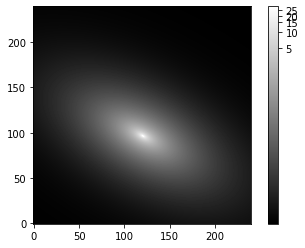

In [21]:
ny, nx = 240, 240

y, x = np.mgrid[0:ny, 0:nx]
sersic_model = models.Sersic2D(
    amplitude=1, r_eff=20, n=2.5, x_0=120.5, y_0=96.5,
    ellip=0.5, theta=-0.5)

image = sersic_model(x, y)

plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))
plt.colorbar()

Convolving with a PSF

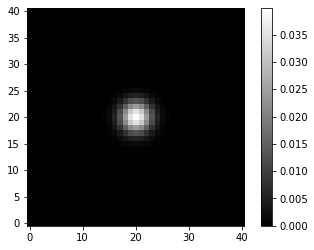

In [6]:
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')
plt.colorbar()

Convolve the image with the PSF

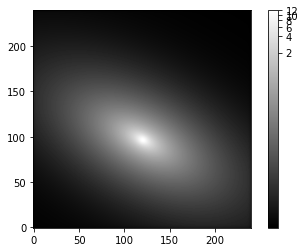

In [7]:
image = convolve(image, psf)
plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))
plt.colorbar()

Adding noise

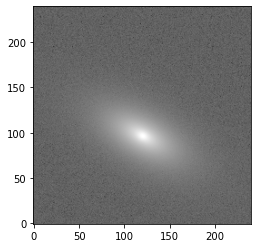

In [9]:
np.random.seed(1)
snp = 100.0
image += (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))

Gain and weight maps

In [10]:
gain = 10000.0

Creating a segmentation map

In [11]:
threshold = photutils.detect_threshold(image, 1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image, threshold, npixels)

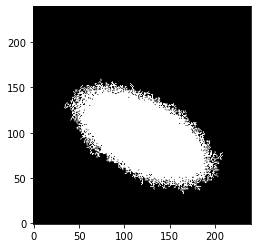

In [12]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

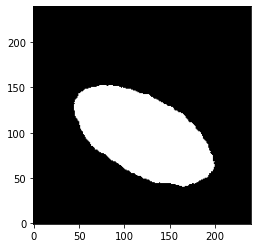

In [13]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

# Running statmorph

Measuring morphological parameters

In [14]:
start = time.time()
source_morphs = statmorph.source_morphology(
    image, segmap, gain=gain, psf=psf)
print('Time: %g s.' % (time.time() - start))

Time: 0.704702 s.


In [16]:
morph = source_morphs[0]

In [17]:
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

xc_centroid = 120.57974325587848
yc_centroid = 96.54876631751854
ellipticity_centroid = 0.49504651780554065
elongation_centroid = 1.980380441489651
orientation_centroid = -0.5025297323963465
xc_asymmetry = 120.49795192600573
yc_asymmetry = 96.5041141987735
ellipticity_asymmetry = 0.49503516784340607
elongation_asymmetry = 1.9803359289977076
orientation_asymmetry = -0.5025187596927418
rpetro_circ = 32.10584845059098
rpetro_ellip = 43.15534223145788
rhalf_circ = 14.607365607744995
rhalf_ellip = 19.197894171055044
r20 = 5.072220422468955
r80 = 26.11103164489153
Gini = 0.5674867473634592
M20 = -2.0732158593833145
F(G, M20) = 0.2857979900017602
S(G, M20) = -0.053365124564456135
sn_per_pixel = 55.04891460404779
C = 3.558129563859544
A = -0.0003891696891799785
S = 0.010867687703064228
sersic_amplitude = 1.0017449025553997
sersic_rhalf = 19.980728153552583
sersic_n = 2.496959225794021
sersic_xc = 120.50130875759518
sersic_yc = 96.50065293649406
sersic_ellip = 0.49994266664181636
sersic_theta =

Examining the fitted Sersic profile

Text(0.5, 1.0, 'Residual')

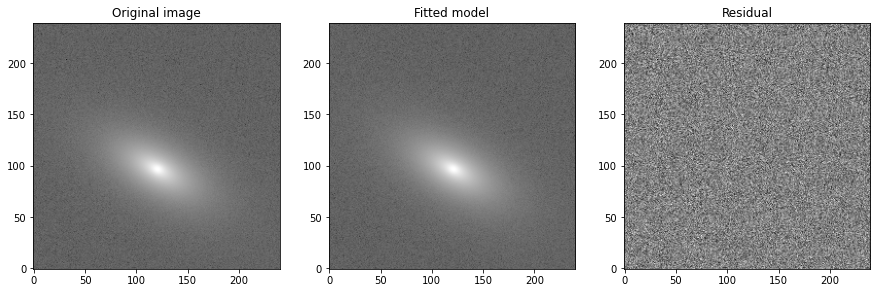

In [18]:
ny, nx = image.shape
y, x = np.mgrid[0:ny, 0:nx]
fitted_model = statmorph.ConvolvedSersic2D(
    amplitude=morph.sersic_amplitude,
    r_eff=morph.sersic_rhalf,
    n=morph.sersic_n,
    x_0=morph.sersic_xc,
    y_0=morph.sersic_yc,
    ellip=morph.sersic_ellip,
    theta=morph.sersic_theta)
fitted_model.set_psf(psf)  # required when using ConvolvedSersic2D
image_model = fitted_model(x, y)
bg_noise = (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.imshow(image, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))
ax.set_title('Original image')
ax = fig.add_subplot(132)
ax.imshow(image_model + bg_noise, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))
ax.set_title('Fitted model')
ax = fig.add_subplot(133)
residual = image - image_model
ax.imshow(residual, cmap='gray', origin='lower',
           norm=simple_norm(residual, stretch='linear'))
ax.set_title('Residual')

Examining other morphological diagnostics

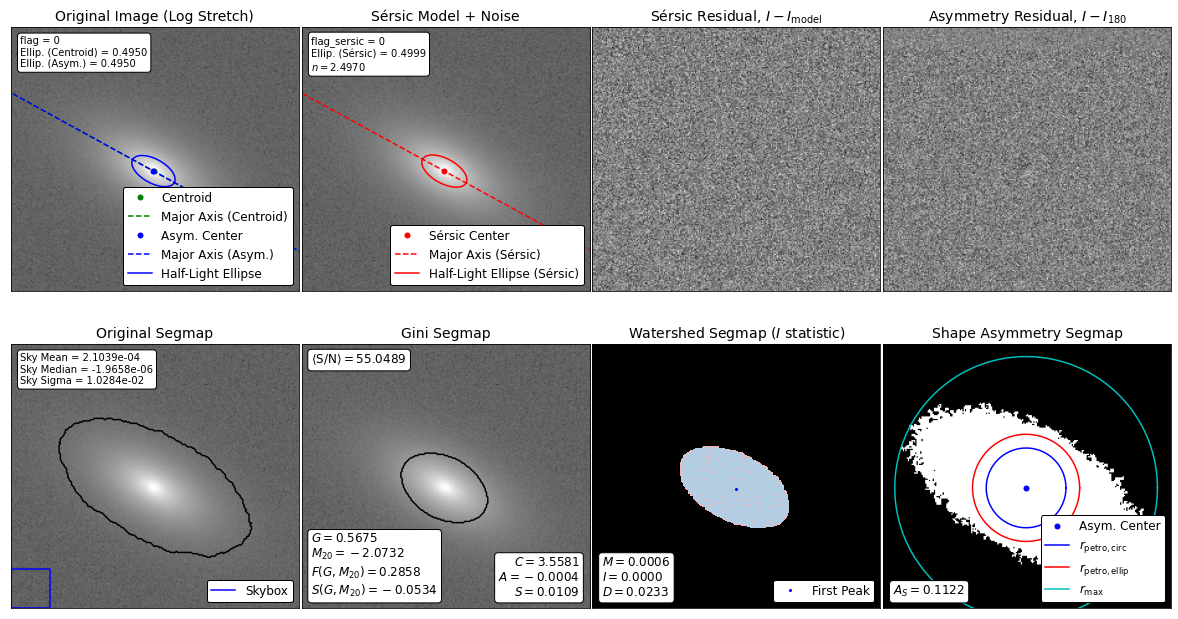

In [19]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)